# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.
keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin", "Car name"]

[LINEAR] Test MAE: 17.656 MPG | Test MSE: 329.787
[MLP]    Test MAE: 1.807 MPG | Test MSE: 6.023


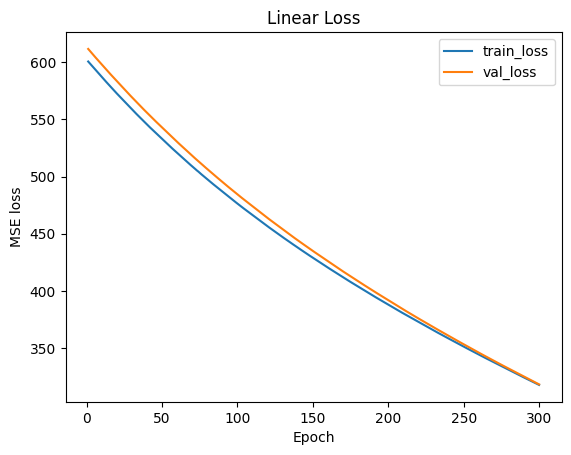

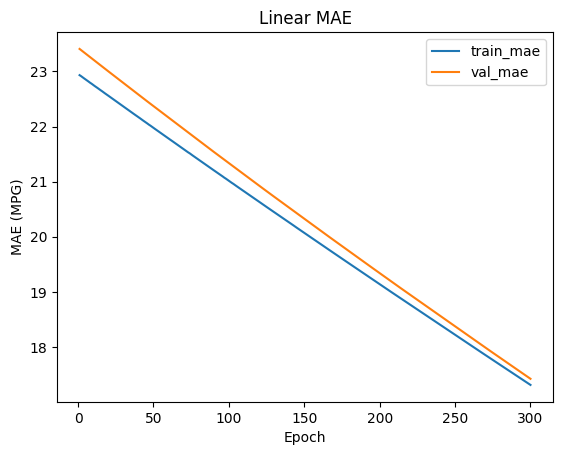

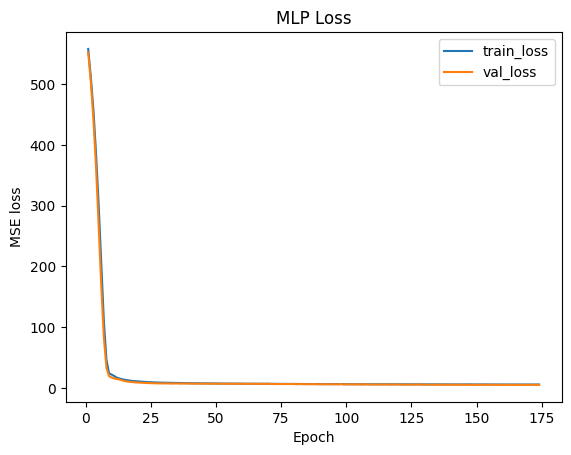

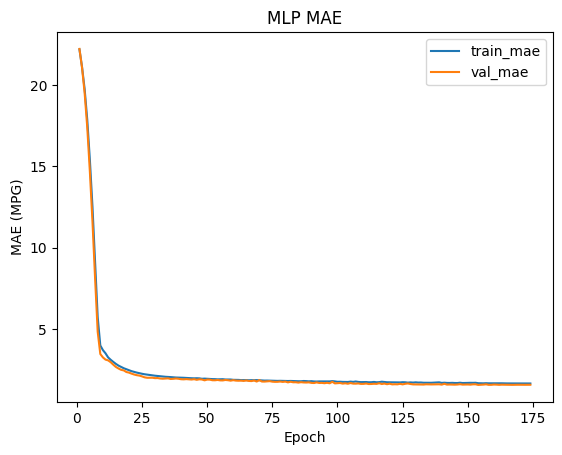

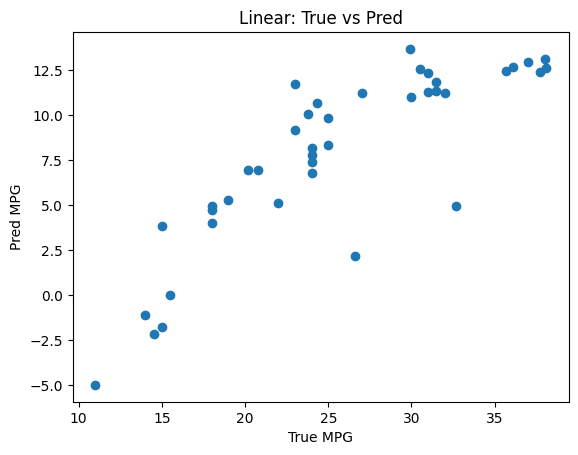

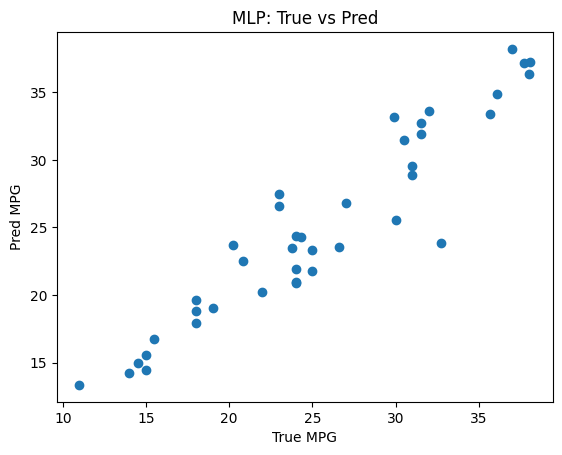

In [ ]:


# =========================
# 1) Cargar Auto MPG (UCI)
# =========================
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
cols = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model_year","origin","car_name"]

raw = pd.read_csv(
    url,
    names=cols,
    na_values="?",
    comment="\t",
    sep=r"\s+",
    skipinitialspace=True
)

# =========================
# 2) Limpieza mínima
# =========================
df = raw.dropna().copy()
df["horsepower"] = df["horsepower"].astype(float)

# origin (1/2/3) como categórica string para StringLookup
df["origin"] = df["origin"].astype(int).astype(str)

# car_name fuera para baseline
df = df.drop(columns=["car_name"])

# =========================
# 3) Split train/val/test
# =========================
rng = 42
df = df.sample(frac=1.0, random_state=rng).reset_index(drop=True)

n = len(df)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)

train_df = df.iloc[:n_train].copy()
val_df   = df.iloc[n_train:n_train + n_val].copy()
test_df  = df.iloc[n_train + n_val:].copy()

y_train = train_df.pop("mpg").astype(np.float32).values
y_val   = val_df.pop("mpg").astype(np.float32).values
y_test  = test_df.pop("mpg").astype(np.float32).values

num_features = ["cylinders","displacement","horsepower","weight","acceleration","model_year"]
cat_features = ["origin"]

# =========================
# 4) tf.data input pipeline
# =========================
def df_to_inputs(dframe: pd.DataFrame):
    out = {}
    for f in num_features:
        out[f] = dframe[f].astype(np.float32).values
    out["origin"] = dframe["origin"].astype(str).values
    return out

def make_ds(dframe: pd.DataFrame, y: np.ndarray, batch_size=32, shuffle=False):
    x = df_to_inputs(dframe)
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dframe), seed=rng, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

batch_size = 32
train_ds = make_ds(train_df, y_train, batch_size=batch_size, shuffle=True)
val_ds   = make_ds(val_df,   y_val,   batch_size=batch_size, shuffle=False)
test_ds  = make_ds(test_df,  y_test,  batch_size=batch_size, shuffle=False)

# =========================
# 5) Preprocesado Keras (adapt SOLO train)
# =========================
# Normalization para numéricas
normalizer = layers.Normalization()
normalizer.adapt(np.stack([train_df[f].values for f in num_features], axis=1))

# One-hot para origin
origin_lookup = layers.StringLookup(output_mode="one_hot")
origin_lookup.adapt(train_df["origin"].values)

def build_model(kind="mlp"):
    # Inputs
    num_inputs = {name: keras.Input(shape=(1,), name=name) for name in num_features}
    origin_in  = keras.Input(shape=(1,), dtype="string", name="origin")

    # num stack + normalize
    num_stack = layers.Concatenate()(list(num_inputs.values()))
    num_norm  = normalizer(num_stack)

    # cat onehot
    origin_oh = origin_lookup(origin_in)

    # concat
    x = layers.Concatenate()([num_norm, origin_oh])

    if kind == "linear":
        # baseline lineal (equivale a regresión lineal sobre features ya procesadas)
        out = layers.Dense(1)(x)
    else:
        # MLP
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(64, activation="relu")(x)
        out = layers.Dense(1)(x)

    model = keras.Model(inputs={**num_inputs, "origin": origin_in}, outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

# =========================
# 6) Callbacks
# =========================
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_mae", patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=8, min_lr=1e-6),
]

# =========================
# 7) Entrenar baseline vs MLP
# =========================
linear = build_model("linear")
hist_linear = linear.fit(train_ds, validation_data=val_ds, epochs=300, verbose=0, callbacks=callbacks)

mlp = build_model("mlp")
hist_mlp = mlp.fit(train_ds, validation_data=val_ds, epochs=300, verbose=0, callbacks=callbacks)

# =========================
# 8) Evaluación
# =========================
lin_loss, lin_mae = linear.evaluate(test_ds, verbose=0)
mlp_loss, mlp_mae = mlp.evaluate(test_ds, verbose=0)

print(f"[LINEAR] Test MAE: {lin_mae:.3f} MPG | Test MSE: {lin_loss:.3f}")
print(f"[MLP]    Test MAE: {mlp_mae:.3f} MPG | Test MSE: {mlp_loss:.3f}")

# =========================
# 9) Plots (loss y MAE)
# =========================
def plot_history(h, title_prefix=""):
    history = h.history
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, history["mae"], label="train_mae")
    plt.plot(epochs, history["val_mae"], label="val_mae")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (MPG)")
    plt.title(f"{title_prefix} MAE")
    plt.legend()
    plt.show()

plot_history(hist_linear, "Linear")
plot_history(hist_mlp, "MLP")

# =========================
# 10) Predicciones + scatter (y_true vs y_pred)
# =========================
y_pred_lin = linear.predict(test_ds, verbose=0).flatten()
y_pred_mlp = mlp.predict(test_ds, verbose=0).flatten()

plt.figure()
plt.scatter(y_test, y_pred_lin)
plt.xlabel("True MPG")
plt.ylabel("Pred MPG")
plt.title("Linear: True vs Pred")
plt.show()

plt.figure()
plt.scatter(y_test, y_pred_mlp)
plt.xlabel("True MPG")
plt.ylabel("Pred MPG")
plt.title("MLP: True vs Pred")
plt.show()


Importelo usando pandas.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight",
                "Acceleration", "Model Year", "Origin", "Car name"]

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

raw_dataset = pd.read_csv(
    url,
    names=column_names,
    na_values="?",
    comment="\t",
    sep=r"\s+",
    skipinitialspace=True
)

raw_dataset.head()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


### Limpia los datos

Trata los missings y variables categóricas

In [4]:
# Copia para trabajar
dataset = raw_dataset.copy()

# 1) Missings
dataset = dataset.dropna().reset_index(drop=True)

# 2) Tipos
dataset["Horsepower"] = dataset["Horsepower"].astype(float)

# 3) Variables categóricas:
# - "Origin" la pasamos a categorías one-hot
dataset["Origin"] = dataset["Origin"].astype(int)

# - "Car name" la quitamos (texto libre, alta cardinalidad) para este ejercicio base
dataset = dataset.drop(columns=["Car name"])

dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 24.6 KB


In [5]:
dataset = pd.get_dummies(dataset, columns=["Origin"], prefix="Origin", drop_first=False)
dataset.head()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,True,False,False
1,15.0,8,350.0,165.0,3693.0,11.5,70,True,False,False
2,18.0,8,318.0,150.0,3436.0,11.0,70,True,False,False
3,16.0,8,304.0,150.0,3433.0,12.0,70,True,False,False
4,17.0,8,302.0,140.0,3449.0,10.5,70,True,False,False


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=SEED)
test_dataset  = dataset.drop(train_dataset.index)

train_dataset = train_dataset.reset_index(drop=True)
test_dataset  = test_dataset.reset_index(drop=True)

print("Train shape:", train_dataset.shape)
print("Test  shape:", test_dataset.shape)


Train shape: (314, 10)
Test  shape: (78, 10)


### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

Tambien revise las estadisticas generales:

In [7]:
# Estadísticas generales (train)
train_dataset.describe().T


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.153822,7.861854,9.0,17.000,22.0,28.075,46.6
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.000,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.000,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.000,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.750,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.000,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.000,82.0


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

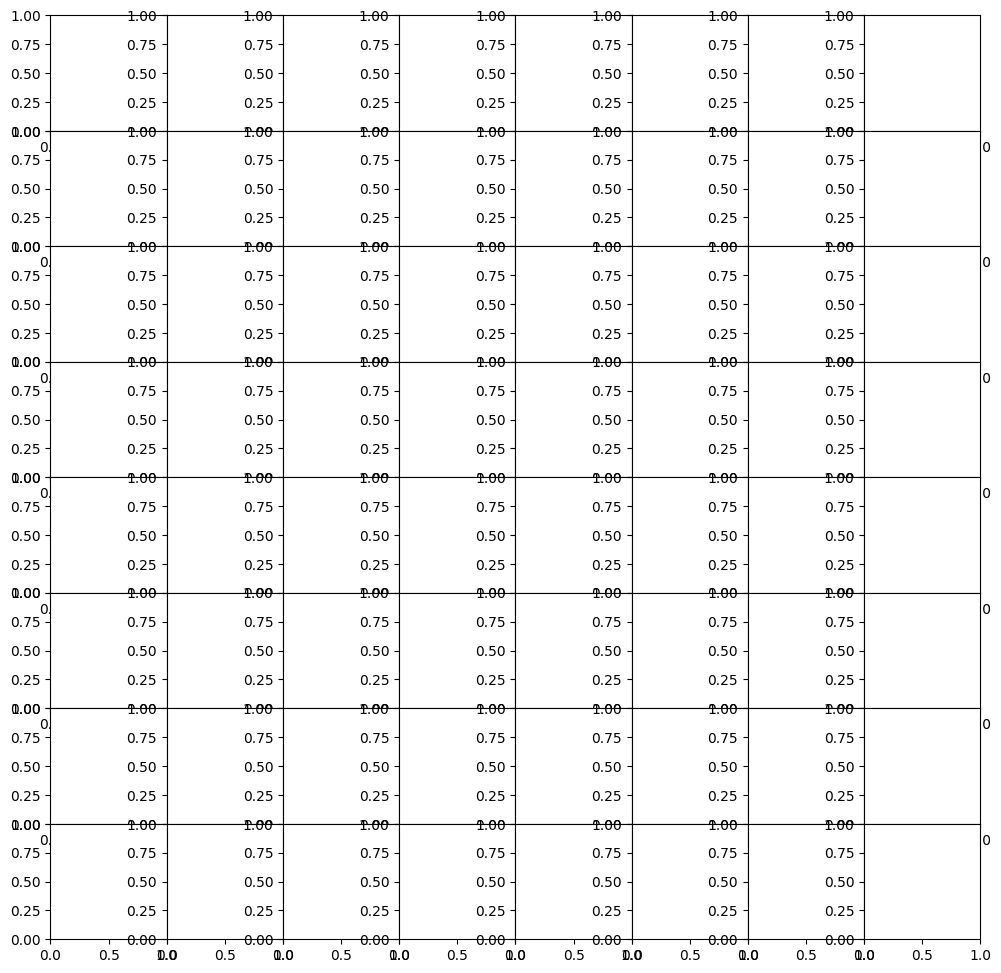

In [8]:
# Grid rápido de distribución conjunta en train (sin seaborn)
cols_to_plot = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight",
                "Acceleration", "Model Year"] + [c for c in train_dataset.columns if c.startswith("Origin_")]

# Limitamos a un subconjunto razonable si hace falta
plot_cols = cols_to_plot[:8]  # ajusta si quieres más

pd.plotting.scatter_matrix(
    train_dataset[plot_cols],
    figsize=(12, 12),
    diagonal="hist",
    alpha=0.6
)
plt.suptitle("Scatter-matrix (Train) - Vista rápida", y=1.02)
plt.show()


### Separa las features del target

Separe el target de las features.

In [9]:
train_features = train_dataset.drop(columns=["MPG"])
test_features  = test_dataset.drop(columns=["MPG"])

train_labels = train_dataset["MPG"].astype(np.float32)
test_labels  = test_dataset["MPG"].astype(np.float32)

train_features.head()


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,4,96.0,69.0,2189.0,18.0,72,False,True,False
1,4,121.0,115.0,2795.0,15.7,78,False,True,False
2,4,91.0,60.0,1800.0,16.4,78,False,False,True
3,4,91.0,70.0,1955.0,20.5,71,True,False,False
4,4,140.0,86.0,2790.0,15.6,82,True,False,False


### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

Estos datos estandarizados es lo que usaremos para entrenar el modelo.

In [ ]:
normalizer = layers.Normalization(axis=-1)

# adapt SOLO con train 
normalizer.adapt(np.array(train_features, dtype=np.float32))

# (opcional) comprobar media ~0 y var ~1 tras normalizar en train
normed_train_preview = normalizer(np.array(train_features[:5], dtype=np.float32)).numpy()
normed_train_preview


array([[-0.88715637, -0.9578954 , -0.9342474 , -0.95225936,  0.88927853,
        -1.0618277 , -1.2888044 ,  2.1942687 , -0.50596446],
       [-0.88715637, -0.72278315,  0.22814986, -0.24571191,  0.06758328,
         0.5672306 , -1.2888044 ,  2.1942687 , -0.50596446],
       [-0.88715637, -1.0049179 , -1.161673  , -1.4058021 ,  0.31766436,
         0.5672306 , -1.2888044 , -0.45573273,  1.9764236 ],
       [-0.88715637, -1.0049179 , -0.90897787, -1.2250845 ,  1.7824254 ,
        -1.3333374 ,  0.77591294, -0.45573273, -0.50596446],
       [-0.88715637, -0.5440978 , -0.5046658 , -0.25154153,  0.03185761,
         1.6532694 ,  0.77591294, -0.45573273, -0.50596446]],
      dtype=float32)

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [11]:
def build_model(n_features: int) -> keras.Model:
    model = keras.Sequential([
        keras.Input(shape=(n_features,)),
        normalizer,                         # usa normalización dentro del modelo
        layers.Dense(64, activation="relu"), # puedes cambiar neuronas si quieres
        layers.Dense(64, activation="relu"),
        layers.Dense(1)                      # salida continua (regresión)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(
        loss="mse",
        optimizer=optimizer,
        metrics=["mae", "mse"]
    )
    return model

model = build_model(train_features.shape[1])


### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [12]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,884 (19.08 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 19 (80.00 B)

### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [13]:
history = model.fit(
    np.array(train_features, dtype=np.float32),
    np.array(train_labels, dtype=np.float32),
    epochs=1000,
    validation_split=0.2,
    verbose=0  # pon 1 si quieres ver cada epoch
)

history


Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

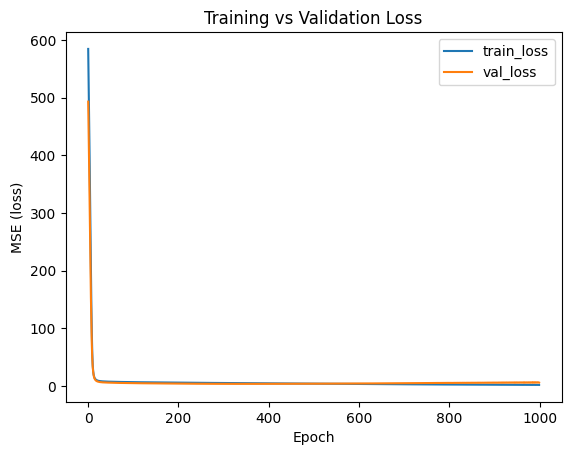

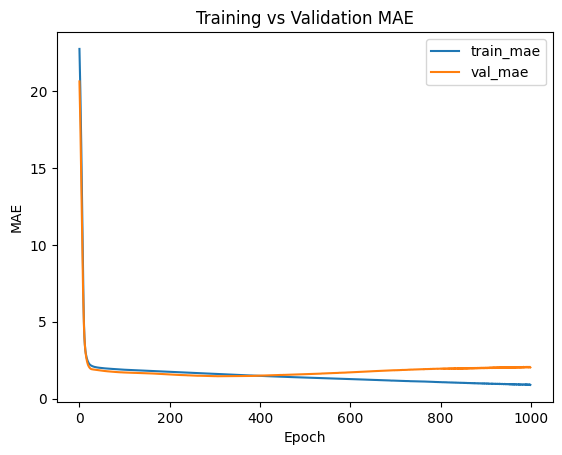

In [14]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

# Loss (MSE)
plt.figure()
plt.plot(hist["epoch"], hist["loss"], label="train_loss")
plt.plot(hist["epoch"], hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (loss)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# MAE
plt.figure()
plt.plot(hist["epoch"], hist["mae"], label="train_mae")
plt.plot(hist["epoch"], hist["val_mae"], label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training vs Validation MAE")
plt.legend()
plt.show()


¿Alguna conclusión respecto a este gráfico?

Los gráficos muestran una **convergencia rápida y estable** del modelo, con una caída pronunciada del error (MSE y MAE) en las primeras decenas de epochs, lo que indica que la mayor parte de la estructura del problema es capturada tempranamente. La **proximidad entre las curvas de entrenamiento y validación** sugiere una buena capacidad de generalización y ausencia de sobreajuste significativo. No obstante, el **ligero incremento del error de validación en las últimas epochs**, mientras el error de entrenamiento continúa disminuyendo, apunta al inicio de un **overfitting leve**, consistente con un entrenamiento excesivamente prolongado. En conjunto, el modelo presenta un rendimiento sólido y bien regularizado, alcanzando un MAE cercano a ~2 MPG, lo que representa un error relativo bajo para este dominio, y sugiere que una estrategia de *early stopping* habría sido suficiente para obtener un modelo óptimo con menor coste computacional.


Earlystopping me ha ayudado a detener el entrenamiento para no caer en overfitting, también para ahorrar recursos innecesarios.

Observamos que si le damos muchas epochs al entrenamiento tiende a un overfitting, siendo el error en validación cada vez más alto. Sería interesante utilizar un número aprox de 30 epochs

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Visualiza el progreso de entrenamiento.

In [15]:
from tensorflow import keras
import numpy as np

history = model.fit(
    np.array(train_features, dtype=np.float32),
    np.array(train_labels, dtype=np.float32),
    epochs=1000,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)


Interpreta el gráfico

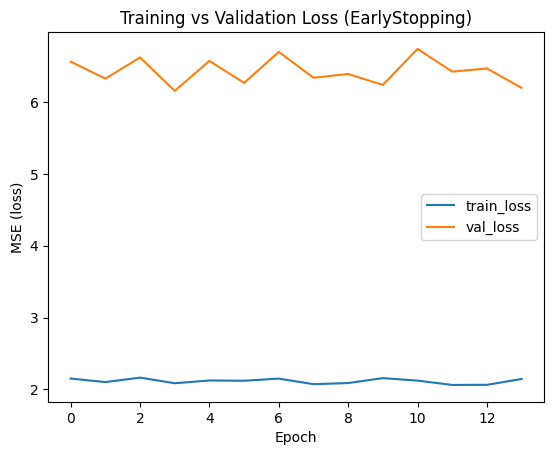

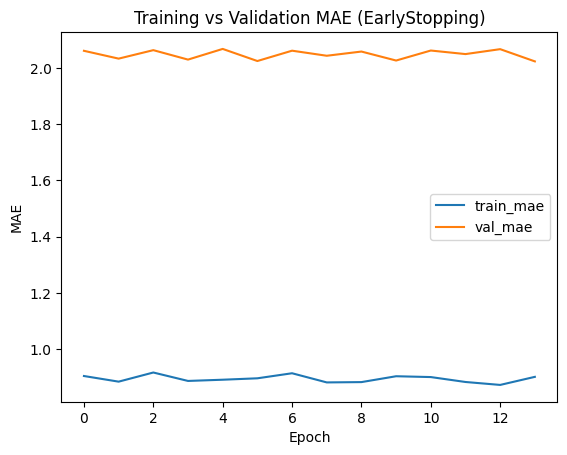

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

plt.figure()
plt.plot(hist["epoch"], hist["loss"], label="train_loss")
plt.plot(hist["epoch"], hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (loss)")
plt.title("Training vs Validation Loss (EarlyStopping)")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist["epoch"], hist["mae"], label="train_mae")
plt.plot(hist["epoch"], hist["val_mae"], label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training vs Validation MAE (EarlyStopping)")
plt.legend()
plt.show()


Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

Ahora prueba el modelo. Coge 10 ejemplos de test y llama a` model.predict`.

In [17]:
loss, mae, mse = model.evaluate(
    np.array(test_features, dtype=np.float32),
    np.array(test_labels, dtype=np.float32),
    verbose=0
)

print(f"Test loss (MSE): {loss:.4f}")
print(f"Test MAE:        {mae:.4f}")
print(f"Test MSE:        {mse:.4f}")


Test loss (MSE): 7.6837
Test MAE:        2.1695
Test MSE:        7.6837


In [18]:
x10 = np.array(test_features.iloc[:10], dtype=np.float32)
y10 = np.array(test_labels.iloc[:10], dtype=np.float32)

pred10 = model.predict(x10, verbose=0).flatten()

print("True MPG:", np.round(y10, 2))
print("Pred MPG:", np.round(pred10, 2))


True MPG: [15. 14. 25. 24. 17. 13. 23. 28. 30. 31.]
Pred MPG: [16.54 16.34 23.53 25.78 17.57 11.19 28.68 24.95 26.92 29.62]


### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

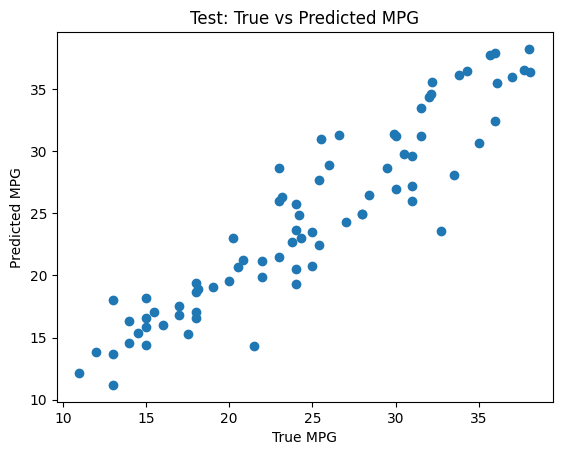

In [19]:
y_pred = model.predict(np.array(test_features, dtype=np.float32), verbose=0).flatten()
y_true = np.array(test_labels, dtype=np.float32)

plt.figure()
plt.scatter(y_true, y_pred)
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.title("Test: True vs Predicted MPG")
plt.show()


Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

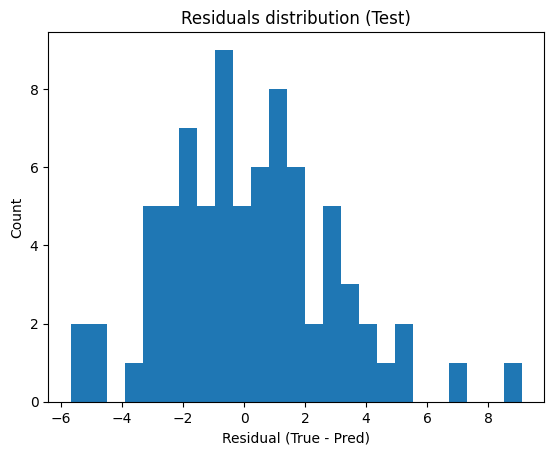

Residual mean: 0.178
Residual std:  2.766


In [20]:
residuals = y_true - y_pred

plt.figure()
plt.hist(residuals, bins=25)
plt.xlabel("Residual (True - Pred)")
plt.ylabel("Count")
plt.title("Residuals distribution (Test)")
plt.show()

print(f"Residual mean: {residuals.mean():.3f}")
print(f"Residual std:  {residuals.std():.3f}")


No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

Guarda tu modelo en un archivo.

In [21]:
model.save("auto_mpg_model.keras")
print("Modelo guardado en: auto_mpg_model.keras")


Modelo guardado en: auto_mpg_model.keras


## Conclusion

Entrenamos  un modelo de regresión con tf.keras para predecir MPG a partir de atributos físicos del vehículo, aplicando limpieza de datos, codificación categórica y estandarización mediante una capa de normalización adaptada solo con entrenamiento. El uso de EarlyStopping permitió seleccionar un punto de entrenamiento con mejor generalización, evitando el sobreajuste por exceso de épocas. La evaluación en el conjunto de test (loss/MAE/MSE) proporciona una estimación realista del rendimiento esperado en datos no vistos, mientras que el scatter de predicción vs valor real y la distribución de residuos permiten diagnosticar sesgos y dispersión del error. Finalmente, el modelo se persistió en disco para su reutilización y despliegue.